## <span style="display: block; text-align: center; font-family: verdana; color: purple;">* Feature Extraction (part 02) for Recipe Recommendar System *</span>

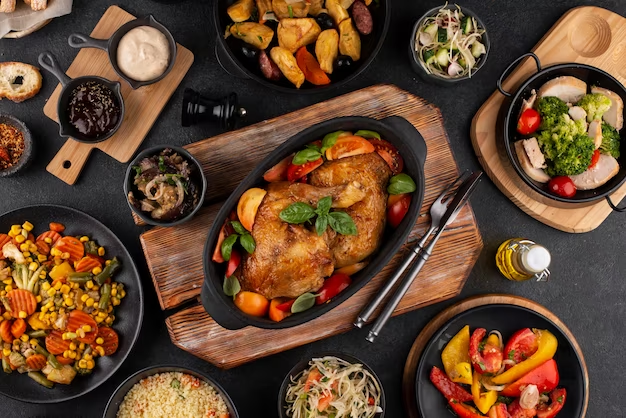
                                                                                                                        
                                                                                                                        
                                                                                                                        By,
                                                                                                                         - Abhishek Kurri
                                                                                                                         - Bidisha Bose Mukherjee
                                                                                                                         - Sejal Sahu
    
 </span>

#### <span style="font-family: verdana; color: purple;">Initial Setup </span>

In [1]:
from pyspark.sql import SparkSession

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1685812078404_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FeatureExtraction_2").getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Run this everytime you create a new spark instance. 

spark.sparkContext.install_pypi_package("plotly==5.5.0")
spark.sparkContext.install_pypi_package("pandas==1.3.5")
spark.sparkContext.install_pypi_package("numpy==1.14.5")
spark.sparkContext.install_pypi_package("matplotlib==3.1.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…







ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

python37-sagemaker-pyspark 1.4.2 requires pyspark==2.4.0, which is not installed.
pandas 1.3.5 requires numpy>=1.17.3; platform_machine != "aarch64" and platform_machine != "arm64" and python_version < "3.10", but you'll have numpy 1.14.5 which is incompatible.


In [5]:
from pyspark.sql import functions as F
from pyspark.ml.feature import Bucketizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyspark.sql.window import Window

# Import for typecasting columns
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType,StringType
from pyspark.sql.types import ArrayType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <span style="font-family: verdana; color: dimgrey;">Defining Custom Functions</span>

In [6]:
def get_quantiles(df, col_name, quantiles_list = [0.01, 0.25, 0.5, 0.75, 0.99]):
    """
    Takes a numerical column and returns column values at requested quantiles

    Inputs 
    Argument 1: Dataframe
    Argument 2: Name of the column
    Argument 3: A list of quantiles you want to find. Default value [0.01, 0.25, 0.5, 0.75, 0.99]

    Output 
    Returns a dictionary with quantiles as keys and column quantile values as values 
    """
    # Get min, max and quantile values for given column
    min_val = df.agg(F.min(col_name)).first()[0]
    max_val = df.agg(F.max(col_name)).first()[0]
    quantiles_vals = df.approxQuantile(col_name,
                                       quantiles_list,
                                       0)
  
    # Store min, quantiles and max in output dict, sequentially
    quantiles_dict = {0.0:min_val}
    quantiles_dict.update(dict(zip(quantiles_list, quantiles_vals)))
    quantiles_dict.update({1.0:max_val})
    return(quantiles_dict)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
def plot_bucketwise_statistics (summary, bucketizer):
    """
    Takes in a dataframe and a bucketizer object and plots the summary statistics for each bucket in the dataframe. 
  
    Inputs
    Argument 1: Pandas dataframe obtained from bucket_col_print_summary function 
    Argument 2: Bucketizer object obtained from bucket_col_print_summary function
  
    Output
    Displays a plot of bucketwise average ratings nunber of ratings of a parameter.   
    """
    # Creating bucket labels from splits
    classlist = bucketizer.getSplits()
    number_of_classes = len(classlist) - 1

    class_labels = []
    hover_labels = []
    for i in range (number_of_classes):
        hover_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) +" (Bucket name: "+ str(int(i)) +")"  )
        class_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) )
  
    summary["Scaled_number"] = (summary["n_ratings"]-summary["n_ratings"].min())/(summary["n_ratings"].max()-summary["n_ratings"].min()) + 1.5
    summary['Bucket_Names'] = class_labels
  
    # making plot
    x = summary["Bucket_Names"]
    y1 = summary["avg_rating"]
    y2 = summary["n_ratings"]
    err = summary["stddev_rating"]  

    # Plot scatter here
    plt.rcParams["figure.figsize"] = [summary.shape[0]+2, 6.0]
    plt.rcParams["figure.autolayout"] = True
    fig, ax1 = plt.subplots()

    bar = ax1.bar(x, y1, color = "#262261")
    ax1.errorbar(x, y1, yerr=err, fmt="o", color="#EE4036")
    ax1.set(ylim=(0, 7))
  
    #ax1.bar_label(bar , fmt='%.2f', label_type='edge')  
    def barlabel(x_list,y_list):
        for i in range(len(x_list)):
            ax1.text(i,y_list[i] + 0.2,y_list[i], ha = 'center',
  			         fontdict=dict(size=10),
  			         bbox=dict(facecolor='#262261', alpha=0.2)         
  			        )
    barlabel(summary["Bucket_Names"].tolist() ,summary["avg_rating"].round(2).tolist())
  
    ax2 = ax1.twinx()
    ax2.scatter(x, y2, s=summary["Scaled_number"]*500, c = '#FAAF40')  
    ax2.set(ylim=(0, summary["n_ratings"].max()*1.15))
    def scatterlabel(x_list,y_list):
  	    for i in range(len(x_list)):
  		    ax2.text(i,y_list[i] + 15000,y_list[i], ha = 'center',
  					 fontdict=dict(size=10),
                     bbox=dict(facecolor='#FAAF40', alpha=0.5)
  					)
    scatterlabel(summary["Bucket_Names"].tolist() ,summary["n_ratings"].tolist())
  
    # giving labels to the axises
    ax1.set_xlabel(bucketizer.getOutputCol(), fontdict=dict(size=14)) 
    ax1.set_ylabel("Average Ratings",fontdict=dict(size=14))
  
    # secondary y-axis label
    ax2.set_ylabel('Number of Ratings',fontdict=dict(size=14))
  
    #plot Title
    plt.title('Bucketwise average ratings and number of ratings for \n'+bucketizer.getInputCol(), 
              fontdict=dict(size=14)) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def bucket_col_print_summary(df, splits, inputCol, outputCol):
    """
    Given a numerical column in a data frame, adds a bucketized version of the column to the data frame, according to splits provided.
    Also prints a summary of ratings seen in each bucket made.

    Inputs 
    Argument 1: Data Frame 
    Argument 2: Values at which the column will be split
    Argument 3: Name of the input column (numerical column)
    Argument 4: Name of the output column (bucketized numerical column)

    Output: 
    1) New dataframe with the output column added
    2) Bucketizer object trained from the input column 
    3) Pandas dataframe with summary statistics for ratings seen in buckets of the output column
    Also plots summary statistics for ratings seen in buckets of the output column
    """

    # Dropping bucket if it already exists
    if outputCol in df.columns:
        df = df.drop(outputCol)

    # Training bucketizer
    bucketizer = Bucketizer(splits = splits,
                            inputCol  = inputCol,
                            outputCol = outputCol)
    
    df = bucketizer.setHandleInvalid("keep").transform(df)

    # Printing meta information on buckets created
    print("Added bucketized column {}".format(outputCol))
    print("")
    print("Bucketing done for split definition: {}".format(splits))
    print("")  
    print("Printing summary statistics for ratings in buckets below:")

    # Creating a summary statistics dataframe and passing it to the plotting function
    summary =  (df
                .groupBy(outputCol)
                .agg(F.avg('rating').alias('avg_rating'),
                     F.stddev('rating').alias('stddev_rating'),
                     F.count('rating').alias('n_ratings'))
                .sort(outputCol)
                .toPandas())
  
    plot_bucketwise_statistics(summary,bucketizer)
  
    return df, bucketizer, summary

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def get_column_distribution_summary(df, col_name):
    """
    Takes a column in a data frame and prints the summary statistics (average, standard deviation, count and distinct count) for all unique values in that column.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Name of the column
  
    Output
    Returns nothing 
    Prints a Dataframe with summary statistics
    """
    print(df
          .groupBy(col_name)
          .agg(F.avg('rating').alias('avg_rating'),
               F.stddev('rating').alias('stddev_rating'),
               F.count('rating').alias('n_ratings'),
               F.countDistinct('id').alias('n_recipes'))
          .sort(F.col(col_name).asc())
          .show(50))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def get_n_items_satisfying_condition (df, condition, aggregation_level = "recipe"):
    """
    Given a condition, find the number of recipes / reviews that match the condition.
    Also calculates the percentage of such recipes / reviews as a percentage of all recipes / reviews.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Logical expression describing a condition, string type. eg: "minutes == 0"
    Argument 3: Aggregation level for determining "items", either  "recipe" or "review". Default value == "recipe"
  
    Output: Returns no object.
    Prints the following:
    1) Number of recipes / reviews that satisfy the condition
    2) Total number of recipes / reviews in the dataframe
    3) Percentage of recipes / reviews that satisfy the condition
    """
    # Find out num rows satisfying the condition
    if aggregation_level == "recipe": 
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id"))).first()[0]
      
        n_rows_total = (df.agg(F.countDistinct("id"))).first()[0]
    if aggregation_level == "review":
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id","user_id"))).first()[0]
        n_rows_total = (df.agg(F.countDistinct("id","user_id"))).first()[0]
  
    # Find out % rows satisfying the conditon and print a properly formatted output
    perc_rows = round(number_of_rows_satisfying_condition * 100/ n_rows_total, 2)
    print('Condition String                   : "{}"'.format(condition))
    print("Num {}s Satisfying Condition   : {} [{}%]".format(aggregation_level.title(), number_of_rows_satisfying_condition, perc_rows))
    print("Total Num {}s                  : {}".format(aggregation_level.title(), n_rows_total))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
def add_OHE_columns (df, n_name_list):
    """
    Given a list of tags, creates one hot encoded columns for each tag. 
  
    Input
    Argument 1: Dataframe in which the function will add the new columns
    Argument 2: list of tags
  
    Output
    Prints the names of columns that have been added 
    Returns the modified dataframe 
    """
    for name in n_name_list:
        df = (df.withColumn("has_tag_"+name, F.when(F.array_contains(df.tags, name), 1).otherwise(0)))
        print ("added column: has_tag_"+name)

    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

###  <span style= "font-family:verdana;color:dimgrey"> Read the data </span>

In [12]:
join_df = spark.read.parquet("s3://aws-emr-resources-294075675661-us-east-1/data/join_df_postEDA.parquet/", header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <span style= "font-family:verdana;color:dimgrey">Adding user level average features </span>

In [13]:
partition = Window.partitionBy("user_id")

join_df = (join_df
                        .withColumn("user_avg_rating",
                                    F.avg(F.col("rating")).over(partition))
                        .withColumn("user_n_ratings",
                                    F.count(F.col("rating")).over(partition))
                        .withColumn("user_avg_years_betwn_review_and_submission",
                                    F.avg(F.col("years_since_submission_on_review_date")).over(partition))
                        .withColumn("user_avg_prep_time_recipes_reviewed",
                                    F.avg(F.col("minutes")).over(partition))
                        .withColumn("user_avg_n_steps_recipes_reviewed",
                                    F.avg(F.col("n_steps")).over(partition))
                        .withColumn("user_avg_n_ingredients_recipes_reviewed",
                                    F.avg(F.col("n_ingredients")).over(partition)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
nutrition_cols = ['calories',
                  'total_fat_per_100_cal',
                  'sugar_per_100_cal',
                  'sodium_per_100_cal',
                  'protein_per_100_cal',
                  'saturated_fat_per_100_cal',
                  'carbohydrates_per_100_cal']

for nutri_col in nutrition_cols:
    join_df = (join_df.withColumn("user_avg_{}_recipes_reviewed".format(nutri_col),F.avg(F.col(nutri_col)).over(partition)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Validation

assert(round(join_df.filter('user_id == 601529').select('user_avg_rating').first()[0], 2) == 4.22)
assert(join_df.filter('user_id == 601529').select('user_n_ratings').first()[0] == 27)
assert(round(join_df.filter('user_id == 601529').select('user_avg_years_betwn_review_and_submission').first()[0], 2) == 3.51)
assert(join_df.filter('user_id == 233044').select('user_avg_prep_time_recipes_reviewed').first()[0] == 50.3)
assert(join_df.filter('user_id == 233044').select('user_avg_n_steps_recipes_reviewed').first()[0] == 8.8)
assert(join_df.filter('user_id == 233044').select('user_avg_n_ingredients_recipes_reviewed').first()[0] == 8.2)
assert(round(join_df.filter('user_id == 233044').select('user_avg_total_fat_per_100_cal_recipes_reviewed').first()[0]) == 6)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<span style= "font-family:verdana;color:dimgrey">

**More Features:**

high_ratings = 5 rating

- `user_avg_years_betwn_review_and_submission_high_ratings`
- `user_avg_prep_time_recipes_reviewed_high_ratings`
- `user_avg_n_steps_recipes_reviewed_high_ratings`
- `user_avg_n_ingredients_recipes_reviewed_high_ratings`
    
</span>

In [16]:
join_df = (join_df
                        .withColumn("ind_5_rating",
                                    F.when(join_df["rating"] != 5, None)
                                     .otherwise(1))
                        .withColumn("years_since_submission_on_review_date_5_ratings",
                                    F.when(join_df["rating"] != 5, None)
                                     .otherwise(F.col("years_since_submission_on_review_date")))
                        .withColumn("minutes_5_ratings",
                                    F.when(join_df["rating"] != 5, None)
                                     .otherwise(F.col("minutes")))
                        .withColumn("n_steps_5_ratings",
                                    F.when(join_df["rating"] != 5, None)
                                     .otherwise(F.col("n_steps")))
                        .withColumn("n_ingredients_5_ratings",
                                    F.when(join_df["rating"] != 5, None)
                                     .otherwise(F.col("n_ingredients"))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
partition = Window.partitionBy("user_id")

join_df = (join_df
                        .withColumn("user_n_5_ratings",
                                    F.sum(F.col("ind_5_rating")).over(partition))
                        .withColumn("user_avg_years_betwn_review_and_submission_5_ratings",
                                    F.avg(F.col("years_since_submission_on_review_date_5_ratings")).over(partition))
                        .withColumn("user_avg_prep_time_recipes_reviewed_5_ratings",
                                    F.avg(F.col("minutes_5_ratings")).over(partition))
                        .withColumn("user_avg_n_steps_recipes_reviewed_5_ratings",
                                    F.avg(F.col("n_steps_5_ratings")).over(partition))
                        .withColumn("user_avg_n_ingredients_recipes_reviewed_5_ratings",
                                    F.avg(F.col("n_ingredients_5_ratings")).over(partition)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
for nutri_col in nutrition_cols:
    join_df = (join_df
                            .withColumn("{}_5_ratings".format(nutri_col),
                                        F.when(join_df["rating"] != 5, None)
                                         .otherwise(F.col(nutri_col))))
    
    join_df = (join_df
                            .withColumn("user_avg_{}_recipes_reviewed_5_ratings".format(nutri_col),
                                        F.avg(F.col("{}_5_ratings".format(nutri_col))).over(partition)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Check - All rows with ratings should have non-null values in corresponding user_avg_5_ratings columns

assert(join_df
       .filter("rating == 5")
       .filter(join_df.user_n_5_ratings.isNull() |
               join_df.user_avg_years_betwn_review_and_submission_5_ratings.isNull() |
               join_df.user_avg_prep_time_recipes_reviewed_5_ratings.isNull() |
               join_df.user_avg_n_steps_recipes_reviewed_5_ratings.isNull() |
               join_df.user_avg_n_ingredients_recipes_reviewed_5_ratings.isNull())
       .count() == 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Check values for a given user id

assert(join_df.filter('user_id == 233044').select('user_n_5_ratings').first()[0] == 7)
assert(round(join_df.filter('user_id == 233044').select('user_avg_years_betwn_review_and_submission_5_ratings').first()[0], 2) == 2.24)
assert(round(join_df.filter('user_id == 233044').select('user_avg_prep_time_recipes_reviewed_5_ratings').first()[0]) == 46)
assert(round(join_df.filter('user_id == 233044').select('user_avg_n_steps_recipes_reviewed_5_ratings').first()[0], 2) == 7.29)
assert(round(join_df.filter('user_id == 233044').select('user_avg_n_ingredients_recipes_reviewed_5_ratings').first()[0], 2) == 6.86)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
join_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- user_id: integer (nullable = true)
 |-- recipe_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- contributor_id: integer (nullable = true)
 |-- submitted: date (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- nutrition: string (nullable = true)
 |-- n_steps: integer (nullable = true)
 |-- steps: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- n_ingredients: integer (nullable = true)
 |-- calories: float (nullable = true)
 |-- total_fat_PDV: float (nullable = true)
 |-- sugar_PDV: float (nullable = true)
 |-- sodium_PDV: float (nullable = true)
 |-- protein_PDV: float (nullable = true)
 |-- saturated_fat_PDV: float (nullable = true)
 |-- carboh

### <span style= "font-family:verdana;color:dimgrey">Tags level EDA</span>

In [22]:
join_tag_level_df = join_df.withColumn('individual_tag',F.explode('tags'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
tags_ratings_summary = (join_tag_level_df
                        .groupBy('individual_tag').agg(F.avg('rating').alias('avg_user_rating'),
#                                                      F.max('rating').alias('max_user_rating'),
#                                                      F.min('rating').alias('min_user_rating'),
                                                       F.count('rating').alias('n_user_ratings'),
                                                       F.countDistinct('id').alias('n_recipes')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
interactions, recipes  =  join_df.count(), join_df.agg(F.countDistinct('id')).first()[0]

tags_ratings_summary = (tags_ratings_summary.withColumn("in_percent_recipies", F.col ("n_recipes")/F.lit(recipes))
                                            .withColumn("in_percent_interactions", F.col ("n_user_ratings")/F.lit(interactions)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### <span style= "font-family:verdana;color:dimgrey"> 1. Top ```n``` most rated tags </span>

In [25]:
tags_ratings_summary.sort(F.col("n_user_ratings").desc()).show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+------------------+--------------+---------+-------------------+-----------------------+
|    individual_tag|   avg_user_rating|n_user_ratings|n_recipes|in_percent_recipies|in_percent_interactions|
+------------------+------------------+--------------+---------+-------------------+-----------------------+
|       preparation|4.4119124813277715|       1123326|   229318| 0.9952779007491125|     0.9970859455232471|
|      time-to-make| 4.414416558383976|       1105132|   224098| 0.9726222407402585|       0.98093659823417|
|            course| 4.412402044928726|       1071920|   217130| 0.9423799727437654|     0.9514569828574067|
|           dietary| 4.412032038984685|        901277|   163918| 0.7114311259255401|     0.7999909462821618|
|   main-ingredient| 4.424040070642098|        864074|   169549| 0.7358705936477349|     0.7669688418963456|
|              easy|4.4183637556952755|        630786|   125789| 0.5459449840715953|     0.5598978882646952|
|          occasion

<span style= "font-family:verdana;color:dimgrey"> Drop tags present in majority of recipes. </span>

In [26]:
tags_ratings_summary = tags_ratings_summary.filter(tags_ratings_summary.in_percent_interactions < 0.75)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
top_most_frequent_tags = tags_ratings_summary.sort(F.col("n_user_ratings").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
get_quantiles(df = top_most_frequent_tags , 
              col_name = 'in_percent_interactions', 
              quantiles_list = [0.01,0.25,0.5, 0.75,0.8,0.85,0.9,0.95, 0.99])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 8.876193959039915e-07, 0.01: 8.876193959039915e-07, 0.25: 0.00035948585534111656, 0.5: 0.0034235480100016954, 0.75: 0.018886765506045133, 0.8: 0.02746826982564492, 0.85: 0.04430729738533955, 0.9: 0.08068815356525645, 0.95: 0.16414301678754564, 0.99: 0.34091596995940915, 1.0: 0.5598978882646952}

In [29]:
# keep tags appearing in the top 5 percentile 

top_most_frequent_tags = top_most_frequent_tags.filter("in_percent_interactions > 0.16")

top_most_frequent_tags.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

29

In [30]:
top_frequent_tags_list = [data[0] for data in top_most_frequent_tags.select('individual_tag').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
join_df = add_OHE_columns (join_df, top_frequent_tags_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

added column: has_tag_easy
added column: has_tag_occasion
added column: has_tag_equipment
added column: has_tag_cuisine
added column: has_tag_low-in-something
added column: has_tag_main-dish
added column: has_tag_60-minutes-or-less
added column: has_tag_number-of-servings
added column: has_tag_meat
added column: has_tag_taste-mood
added column: has_tag_north-american
added column: has_tag_30-minutes-or-less
added column: has_tag_vegetables
added column: has_tag_oven
added column: has_tag_4-hours-or-less
added column: has_tag_low-carb
added column: has_tag_holiday-event
added column: has_tag_desserts
added column: has_tag_healthy
added column: has_tag_dinner-party
added column: has_tag_15-minutes-or-less
added column: has_tag_low-sodium
added column: has_tag_american
added column: has_tag_beginner-cook
added column: has_tag_low-cholesterol
added column: has_tag_low-calorie
added column: has_tag_inexpensive
added column: has_tag_comfort-food
added column: has_tag_kid-friendly

#### <span style= "font-family:verdana;color:dimgrey"> 2.  Bottom ```n``` least rated tags </span>

In [32]:
tags_ratings_summary.sort(F.col("n_user_ratings").asc()).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------+---------+--------------------+-----------------------+
|      individual_tag|avg_user_rating|n_user_ratings|n_recipes| in_percent_recipies|in_percent_interactions|
+--------------------+---------------+--------------+---------+--------------------+-----------------------+
|     cranberry-sauce|            5.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
|           pot-roast|            0.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
|   main-dish-seafood|            0.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
|   ham-and-bean-soup|            4.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
|lamb-sheep-main-dish|            0.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
+--------------------+---------------+--------------+---------+--------------------+-----------------------+
only showing top 5 

#### <span style= "font-family:verdana;color:dimgrey"> 3. Top ```n``` rated tags  </span>

In [33]:
tags_ratings_summary.sort(F.col("avg_user_rating").desc()).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------+---------+--------------------+-----------------------+
|      individual_tag|avg_user_rating|n_user_ratings|n_recipes| in_percent_recipies|in_percent_interactions|
+--------------------+---------------+--------------+---------+--------------------+-----------------------+
|   side-dishes-beans|            5.0|             2|        2|8.680329505308021E-6|   1.775238791807983E-6|
|             cabbage|            5.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
|heirloom-historic...|            5.0|             3|        2|8.680329505308021E-6|   2.662858187711975E-6|
|middle-eastern-ma...|            5.0|             2|        1|4.340164752654011E-6|   1.775238791807983E-6|
|  breakfast-potatoes|            5.0|             1|        1|4.340164752654011E-6|   8.876193959039915E-7|
+--------------------+---------------+--------------+---------+--------------------+-----------------------+
only showing top 5 

<span style= "font-family:verdana;color:dimgrey"> Top rated tags have low number of ratings. </span>

In [34]:
get_quantiles (tags_ratings_summary, "n_user_ratings", quantiles_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.99])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 1, 0.01: 1.0, 0.05: 1.0, 0.1: 12.0, 0.15: 99.0, 0.2: 187.0, 0.25: 405.0, 0.5: 3857.0, 0.75: 21278.0, 0.99: 384079.0, 1.0: 630786}

In [35]:
tags_ratings_summary = tags_ratings_summary.filter(tags_ratings_summary.n_user_ratings > 100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
top_rated_tags_df = tags_ratings_summary.sort(F.col("avg_user_rating").desc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
get_quantiles(df = top_rated_tags_df , 
              col_name = 'avg_user_rating', 
              quantiles_list = [0.01,0.25,0.5, 0.75,0.8,0.85,0.9,0.95, 0.99])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 3.6742424242424243, 0.01: 3.962536023054755, 0.25: 4.344224006718102, 0.5: 4.403587357364895, 0.75: 4.451890903550206, 0.8: 4.461777662606893, 0.85: 4.48284199758207, 0.9: 4.503597122302159, 0.95: 4.536699941280094, 0.99: 4.609756097560975, 1.0: 4.822727272727272}

In [38]:
# keep tags above 95 percentile
top_rated_tags_df = top_rated_tags_df.filter("avg_user_rating > 4.53")

top_rated_tags_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26

In [39]:
top_rated_tags_list = [data[0] for data in top_rated_tags_df.select('individual_tag').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Check if any of the current tags have been added earlier

In [40]:
set(top_frequent_tags_list) & set(top_rated_tags_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

set()

In [41]:
all_added_columns_set = set(top_frequent_tags_list).union(set(top_rated_tags_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
join_df = add_OHE_columns (join_df, top_rated_tags_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

added column: has_tag_ragu-recipe-contest
added column: has_tag_simply-potatoes2
added column: has_tag_non-alcoholic
added column: has_tag_a1-sauce
added column: has_tag_labor-day
added column: has_tag_punch
added column: has_tag_lettuces
added column: has_tag_cocktails
added column: has_tag_mashed-potatoes
added column: has_tag_smoothies
added column: has_tag_turkey-burgers
added column: has_tag_avocado
added column: has_tag_beverages
added column: has_tag_mango
added column: has_tag_asparagus
added column: has_tag_memorial-day
added column: has_tag_shakes
added column: has_tag_strawberries
added column: has_tag_omelets-and-frittatas
added column: has_tag_salsas
added column: has_tag_greek
added column: has_tag_salads
added column: has_tag_barbecue
added column: has_tag_australian
added column: has_tag_grilling
added column: has_tag_polynesian

#### <span style= "font-family:verdana;color:dimgrey">3. Bottom ```n``` rated tags </span>

In [43]:
bottom_rated_tags_df = tags_ratings_summary.sort(F.col("avg_user_rating").asc())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
get_quantiles (bottom_rated_tags_df, "avg_user_rating", quantiles_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.99])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0.0: 3.6742424242424243, 0.01: 3.962536023054755, 0.02: 4.054406964091403, 0.03: 4.096385542168675, 0.04: 4.126760563380282, 0.05: 4.171974522292993, 0.1: 4.238095238095238, 0.15: 4.303225806451613, 0.2: 4.325726141078838, 0.25: 4.344224006718102, 0.5: 4.403587357364895, 0.75: 4.451890903550206, 0.99: 4.609756097560975, 1.0: 4.822727272727272}

In [45]:
bottom_rated_tags_df = bottom_rated_tags_df.filter("avg_user_rating < 4.00")

bottom_rated_tags_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6

In [46]:
bottom_rated_tags_list = [data[0] for data in bottom_rated_tags_df.select('individual_tag').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
all_added_columns_set & set(bottom_rated_tags_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

set()

In [48]:
join_df =  add_OHE_columns(join_df, bottom_rated_tags_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

added column: has_tag_pressure-canning
added column: has_tag_honduran
added column: has_tag_unprocessed-freezer
added column: has_tag_birthday
added column: has_tag_jellies
added column: has_tag_water-bath

### <span style= "font-family:verdana;color:dimgrey">Final DataFrame</span>

In [49]:
len(join_df.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

148

In [50]:
join_df.write.mode('overwrite').parquet('s3://aws-emr-resources-294075675661-us-east-1/data/join_df_ModelReady.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<span style= "font-family:verdana;color:royalblue">Feature extraction (part 02) for model is completed.</span>